<a href="https://colab.research.google.com/github/Sakib97/covid_classification/blob/master/densenet201_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# needed for plotting confusion matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [2]:
from __future__ import print_function, division

from sklearn.metrics import confusion_matrix as sk_confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [3]:
!unzip -qq '/content/drive/My Drive/Colab Notebooks/CT_Scan_Brazil-20200621T154301Z-001.zip'

In [4]:
# Load Data
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/CT_Scan_Brazil'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [5]:
print(class_names)
print(dataloaders)
print(dataset_sizes)

['Covid', 'Non_Covid']
{'train': <torch.utils.data.dataloader.DataLoader object at 0x7f21730a4fd0>, 'val': <torch.utils.data.dataloader.DataLoader object at 0x7f21730a49b0>, 'test': <torch.utils.data.dataloader.DataLoader object at 0x7f21736ce550>}
{'train': 1736, 'val': 496, 'test': 249}


In [6]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    # best_acc = 0.0

    train_acc_values = [] # for plotting purpose
    val_acc_values = [] # for plotting purpose

    best_acc_test = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        # for phase in ['train', 'val','test']:
        for phase in ['train', 'test']: # test is validation now as it contains 10% data
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
              train_acc_values.append(epoch_acc)
            if phase == 'test':
              val_acc_values.append(epoch_acc) # test is validation now as it contains 10% data

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            # if phase == 'val' and epoch_acc > best_acc:
            #     best_acc = epoch_acc
            #     best_model_wts = copy.deepcopy(model.state_dict())
            
            if phase == 'test' and epoch_acc > best_acc_test:
                best_acc_test = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))

    print('Best val Acc: {:4f}'.format(best_acc_test))  # test is validation now as it contains 10% data

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model , train_acc_values , val_acc_values

In [16]:
model_ft = models.densenet201(pretrained=True)
# print(model_ft)

In [17]:
# Finetuning the convnet


num_ftrs = model_ft.classifier.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.classifier = nn.Linear(num_ftrs, 2)

# num_ftrs = model_ft.classifier[6].in_features
# features = list(model_ft.classifier.children())[:-1] # Remove last layer
# features.extend([nn.Linear(num_ftrs, len(class_names))]) # Add our layer with 4 outputs
# model_ft.classifier = nn.Sequential(*features) # Replace the model classifier
# print(vgg16)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [9]:
print(model_ft)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [18]:
model_ft , train_acc_values , val_acc_values = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.6542 Acc: 0.7091
test Loss: 1.0735 Acc: 0.6064

Epoch 1/24
----------
train Loss: 0.5219 Acc: 0.7679
test Loss: 0.5086 Acc: 0.7309

Epoch 2/24
----------
train Loss: 0.4435 Acc: 0.8099
test Loss: 1.1585 Acc: 0.6024

Epoch 3/24
----------
train Loss: 0.4152 Acc: 0.8151
test Loss: 0.8104 Acc: 0.6426

Epoch 4/24
----------
train Loss: 0.3592 Acc: 0.8376
test Loss: 0.7483 Acc: 0.5904

Epoch 5/24
----------
train Loss: 0.3332 Acc: 0.8687
test Loss: 2.4438 Acc: 0.5020

Epoch 6/24
----------
train Loss: 0.3149 Acc: 0.8704
test Loss: 0.9380 Acc: 0.6145

Epoch 7/24
----------
train Loss: 0.2202 Acc: 0.9171
test Loss: 0.4310 Acc: 0.8072

Epoch 8/24
----------
train Loss: 0.2128 Acc: 0.9159
test Loss: 0.7770 Acc: 0.6225

Epoch 9/24
----------
train Loss: 0.1966 Acc: 0.9171
test Loss: 0.8201 Acc: 0.6627

Epoch 10/24
----------
train Loss: 0.1969 Acc: 0.9142
test Loss: 0.7612 Acc: 0.6827

Epoch 11/24
----------
train Loss: 0.1755 Acc: 0.9297
test Loss: 0.8174 Acc

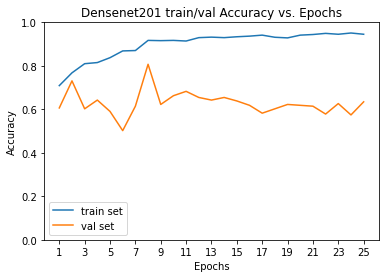

In [22]:
# plotting the curve 
train_acc = []
val_acc = []

# train_acc_values , val_acc_values

train_acc = [h.cpu().numpy() for h in train_acc_values]
val_acc = [h.cpu().numpy() for h in val_acc_values]

plt.title("Densenet201 train/val Accuracy vs. Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(range(1,26),train_acc,label="train set")
plt.plot(range(1,26),val_acc,label="val set")
plt.ylim((0,1.))
plt.xticks(np.arange(1, 26, 2.0))
plt.legend()
plt.show()

In [12]:
def test_acc(model):
    model.eval()
    running_corrects = 0

    nb_classes = 2
    confusion_matrix = torch.zeros(nb_classes, nb_classes)

    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            
            for t, p in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            predlist=torch.cat([predlist,preds.view(-1).cpu()])
            lbllist=torch.cat([lbllist,labels.view(-1).cpu()])

    sk_cm = sk_confusion_matrix(lbllist.numpy(), predlist.numpy())

    # testing_acc = running_corrects.double() / dataset_sizes['test']
    testing_acc = running_corrects.double() / dataset_sizes['val']
    return confusion_matrix , testing_acc ,sk_cm

In [19]:
confusion_matrix , testing_acc ,sk_cm = test_acc(model_ft)
print(confusion_matrix, '\n', testing_acc, '\n',  sk_cm)

tensor([[186.,  64.],
        [  4., 242.]]) 
 tensor(0.8629, device='cuda:0', dtype=torch.float64) 
 [[186  64]
 [  4 242]]


Confusion matrix, without normalization
[[186  64]
 [  4 242]]


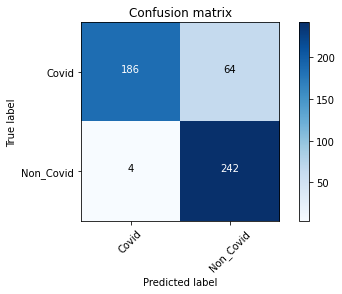

In [21]:
plot_confusion_matrix(sk_cm, class_names)

In [1]:
import numpy as np
sk_cm = np.array([[186.,  64.],
        [  4., 242.]])

tp = sk_cm[0][0]
tn = sk_cm[1][1]
fn = sk_cm[0][1]
fp = sk_cm[1][0]

precision = tp / (tp + fp)
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
f1_score = (2*tp) / (2*tp + fp + fn)
# accuracy = (tp+tn) / dataset_sizes['val']
accuracy = (tp+tn) / 496

print('Precision: {:.2f} %\n Sensitivity: {:.2f} %\n Specificity: {:.2f} %\n F1_scorer: {:.2f} %\n Accuracy: {:.2f} %'.format(precision*100, sensitivity*100, specificity*100, f1_score*100, accuracy*100))

Precision: 97.89 %
 Sensitivity: 74.40 %
 Specificity: 98.37 %
 F1_scorer: 84.55 %
 Accuracy: 86.29 %
